In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
from langdetect import detect 
import html

pd.reset_option('all')

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7550/1210054291.py:8: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7550/1210054291.py:8: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


## Raw data

- score: number of upvotes minus number of downvotes
- link_id (for comments): id of the submission to which the comment responded

In [2]:
submissions_raw = pd.read_csv("raw/homeowners_submissions.csv")
comments_raw = pd.read_csv("raw/homeowners_comments.csv")

In [3]:
submissions_raw.head()

,id,created,author,score,selftext,num_comments,link
0,9siwg,2009-10-09 14:17,u/willies_hat,10,NaN,0,https://www.reddit.com/r/homeowners/comments/9...
1,9sj2g,2009-10-09 14:32,u/metl_lord,6,NaN,0,https://www.reddit.com/r/homeowners/comments/9...
2,9sj3d,2009-10-09 14:35,u/AnnArchist,5,"My homes old too, so I could use the extra tips.",4,https://www.reddit.com/r/homeowners/comments/9...
3,9smtj,2009-10-09 23:17,u/[deleted],1,[deleted],0,https://www.reddit.com/r/homeowners/comments/9...
4,9st9u,2009-10-10 16:11,u/njpest,1,NaN,0,https://www.reddit.com/r/homeowners/comments/9...


In [4]:
comments_raw.head()

,id,link_id,created,author,score,body,link
0,c0e89bn,t3_9sj3d,2009-10-09 14:52,u/metl_lord,1,How old is your home?\n\nI'm preparing my new ...,https://www.reddit.com/r/homeowners/comments/9...
1,c0e89hr,t3_9sj3d,2009-10-09 14:55,u/AnnArchist,1,"1965 so not that old, yet.",https://www.reddit.com/r/homeowners/comments/9...
2,c0e8cz8,t3_9sj3d,2009-10-09 16:04,u/[deleted],1,[deleted],https://www.reddit.com/r/homeowners/comments/9...
3,c0e8d83,t3_9sj3d,2009-10-09 16:09,u/[deleted],1,[deleted],https://www.reddit.com/r/homeowners/comments/9...
4,c0e9fvt,t3_9sj3d,2009-10-10 13:01,u/coffeeffoc,1,What is your source for this? \n\n&gt;If you g...,https://www.reddit.com/r/homeowners/comments/9...


## Data Cleaning

### Missing values

In [5]:
def remove_missing_data(raw_df, column):
    '''
    Filters all entries that have [removed] or [deleted] in their body/self 
    text column (as applicable). Also filters NaN values.
    
    Input: 
        - raw_df: Pandas dataframe
        - column: Target column to look for missing values
    
    Returns:
        - Cleaned dataframe
    '''

    print("DataFrame shape before cleaning:", raw_df.shape)

    #Remove rows with values of "[removed]" or "[deleted]" on body/self text
    to_filter = ["[removed]", "[deleted]", "\[deleted\]"]
    mask = ~raw_df[column].isin(to_filter)
    filtered_df = raw_df[mask]

    print("DataFrame shape after filtering removed values:", 
                                                 filtered_df.shape)
    
    #Filter NaN
    filtered_df = filtered_df.dropna(subset=[column])
    print("DataFrame shape after filtering NaN values:", filtered_df.shape)

    return filtered_df

In [6]:
submissions_filtered1 = remove_missing_data(submissions_raw, "selftext")
submissions_filtered1

DataFrame shape before cleaning: (98937, 7)
DataFrame shape after filtering removed values: (76586, 7)
DataFrame shape after filtering NaN values: (71487, 7)


,id,created,author,score,selftext,num_comments,link
2,9sj3d,2009-10-09 14:35,u/AnnArchist,5,"My homes old too, so I could use the extra tips.",4,https://www.reddit.com/r/homeowners/comments/9...
39,a1bfh,2009-11-05 11:16,u/toinfinitiandbeyond,1,I own a mobile home with very thin walls and a...,2,https://www.reddit.com/r/homeowners/comments/a...
67,a4hd1,2009-11-14 19:29,u/ddrager,3,One thing I had read at one point is that most...,1,https://www.reddit.com/r/homeowners/comments/a...
196,aortt,2010-01-12 13:07,u/txfoundationrpr,0,Blog post examining some of the factors that a...,1,https://www.reddit.com/r/homeowners/comments/a...
306,ci0c4,2010-06-22 23:41,u/wellsdb,2,[http://www.facebook.com/album.php?aid=231261&...,3,https://www.reddit.com/r/homeowners/comments/c...
...,...,...,...,...,...,...,...
98932,18vhqu9,2023-12-31 15:36,u/thebabepee,1,This is something I’ve been contemplating for ...,17,https://www.reddit.com/r/homeowners/comments/1...
98933,18vhucw,2023-12-31 15:41,u/GlorifiedLaundryGuy,1,Hey everyone. Looking for some advice here. Bo...,9,https://www.reddit.com/r/homeowners/comments/1...
98934,18vjq6r,2023-12-31 17:19,u/karntnerkasnudl,1,I've recently bought my first flat in Manchest...,1,https://www.reddit.com/r/homeowners/comments/1...
98935,18vk6d2,2023-12-31 17:44,u/Muab_D1b,3,I’m a first time home buyer and recently close...,5,https://www.reddit.com/r/homeowners/comments/1...


In [7]:
comments_filtered1 = remove_missing_data(comments_raw, "body")
comments_filtered1

DataFrame shape before cleaning: (1475172, 7)
DataFrame shape after filtering removed values: (1416846, 7)
DataFrame shape after filtering NaN values: (1416835, 7)


,id,link_id,created,author,score,body,link
0,c0e89bn,t3_9sj3d,2009-10-09 14:52,u/metl_lord,1,How old is your home?\n\nI'm preparing my new ...,https://www.reddit.com/r/homeowners/comments/9...
1,c0e89hr,t3_9sj3d,2009-10-09 14:55,u/AnnArchist,1,"1965 so not that old, yet.",https://www.reddit.com/r/homeowners/comments/9...
4,c0e9fvt,t3_9sj3d,2009-10-10 13:01,u/coffeeffoc,1,What is your source for this? \n\n&gt;If you g...,https://www.reddit.com/r/homeowners/comments/9...
6,c0e9ke0,t3_9sj3d,2009-10-10 14:56,u/coffeeffoc,1,Thanks I've heard of (and picked up on Google)...,https://www.reddit.com/r/homeowners/comments/9...
7,c0ef0tm,t3_9twgl,2009-10-14 05:32,u/greenbarbara,1,There are a variety of fences available in the...,https://www.reddit.com/r/homeowners/comments/9...
...,...,...,...,...,...,...,...
1475167,kfroeq7,t3_18vh92k,2023-12-31 17:56,u/MortifiedCucumber,1,"Sounds like he’s storing equipment, not operat...",https://www.reddit.com/r/homeowners/comments/1...
1475168,kfrokme,t3_18vc0ad,2023-12-31 17:57,u/shaneacton1,-1,It's free to dig and lay brick. You're a low-i...,https://www.reddit.com/r/homeowners/comments/1...
1475169,kfrom50,t3_18vh92k,2023-12-31 17:57,u/7thAndGreenhill,3,I’d try talking to the guy before potentially ...,https://www.reddit.com/r/homeowners/comments/1...
1475170,kfromsv,t3_18vc0ad,2023-12-31 17:58,u/Leaf-Stars,3,You can cut it or buy it in 12” and 24” pieces...,https://www.reddit.com/r/homeowners/comments/1...


### Duplicates

In [8]:
submissions_filtered2 = submissions_filtered1.drop_duplicates(subset=['selftext'])
comments_filtered2 = comments_filtered1.drop_duplicates(subset=['body'])

print("Submissions df shape before filtering duplicates:", 
                             submissions_filtered1.shape)
    
print("Submissions df shape after filtering duplicates:", 
                             submissions_filtered2.shape)

print("Comments df shape before filtering duplicates:", 
                             comments_filtered1.shape)
    
print("Comments df shape after filtering duplicates:", 
                             comments_filtered2.shape)


Submissions df shape before filtering duplicates: (71487, 7)
Submissions df shape after filtering duplicates: (71335, 7)
Comments df shape before filtering duplicates: (1416835, 7)
Comments df shape after filtering duplicates: (1389318, 7)


### Clean text 

In [9]:
#https://www.w3schools.com/python/ref_string_translate.asp
#https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string

def clean_text(s):
    '''
    Cleans text
    
        Inputs:
            - s (string)
            
        Returns:
            - cleaned string
    '''

    # Decode HTML entities (e.g., &amp;#x200B)
    text = html.unescape(s)

    # Decode again for any remaining HTML entities like &#x200B;
    text = html.unescape(text)
    
    # Remove links
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove zero-width spaces explicitly
    text = text.replace('\u200B', '') 

    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Remove words that have numbers
    text = re.sub(r'\b\w*\d\w*\b', '', text)

    # Remove apostrophes without adding space
    text = re.sub(r"'", '', text)  

    # Replace all other punctuation with space 
    text = re.sub(r"[^\w\s]", ' ', text) 
    
    # Remove line breaks
    text = text.replace('\n', ' ').replace('\r', ' ')

    # Collapse multiple spaces into a single space
    text = re.sub(r'\s+', ' ', text).strip()

    # Lowercase
    text = text.lower()

    # Remove unnecessary whitespace
    return text.strip()
    
submissions_filtered2["cleaned_text"] = submissions_filtered2["selftext"].apply(lambda x: clean_text(x))
comments_filtered2["cleaned_text"] = comments_filtered2["body"].apply(lambda x: clean_text(x))

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7550/1548817189.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered2["cleaned_text"] = submissions_filtered2["selftext"].apply(lambda x: clean_text(x))
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7550/1548817189.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_filtered2["cleaned_text"] = comments_filtered2["body"].apply(lambda x: clean_text(x))


### Delete very short texts

In [10]:
#Create column with word count to identify short texts
submissions_filtered2['word_count'] = submissions_filtered2['cleaned_text'].apply(lambda x: len(x.split()))
comments_filtered2['word_count'] = comments_filtered2['cleaned_text'].apply(lambda x: len(x.split()))

#Filter
print("Submissions shape before dropping short texts:", submissions_filtered2.shape)
submissions_filtered3 = submissions_filtered2[submissions_filtered2.word_count >= 50]
print("Submissions shape after dropping short texts:", submissions_filtered3.shape)

print("Comments shape before dropping short texts:", comments_filtered2.shape)
comments_filtered3 = comments_filtered2[comments_filtered2.word_count >= 50]
print("Comments shape after dropping short texts:", comments_filtered3.shape)

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7550/2268340447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered2['word_count'] = submissions_filtered2['cleaned_text'].apply(lambda x: len(x.split()))


Submissions shape before dropping short texts: (71335, 9)
Submissions shape after dropping short texts: (58302, 9)
Comments shape before dropping short texts: (1389318, 9)
Comments shape after dropping short texts: (440448, 9)


/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7550/2268340447.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_filtered2['word_count'] = comments_filtered2['cleaned_text'].apply(lambda x: len(x.split()))


### Remove non-english posts

In [11]:
def checks_language(text):
    '''
    Checks if the language of the text is english or not
    
        Inputs:
            - s (string)
            
        Returns:
            - Boolean (True if text is in english)
    '''

    #If there's a problem with the text, simply return False
    try: 
        lang = detect(text)
    except:
        return False 
    
    if lang == "en":
        return True
    return False

submissions_filtered3['in_english'] = submissions_filtered3['cleaned_text'].apply(lambda x: checks_language(x))
comments_filtered3['in_english'] = comments_filtered3['cleaned_text'].apply(lambda x: checks_language(x))

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7550/235315306.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered3['in_english'] = submissions_filtered3['cleaned_text'].apply(lambda x: checks_language(x))
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7550/235315306.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_filtered3['in_english'] = comments_filtered3['cleaned_text'].apply(lambda x: checks_language(x))


Filter and only keep entries in english

In [12]:
submissions_filtered4 = submissions_filtered3[submissions_filtered3.in_english]
comments_filtered4 = comments_filtered3[comments_filtered3.in_english]

## Data engineering

### Combine submissions and comments

In [13]:
#Create column to identify them later
submissions_filtered4["type"] = "submission"
comments_filtered4["type"] = "comment"

#Concatenate
submissions_new = submissions_filtered4.rename(columns={'selftext': 'body'}, inplace=False)
complete_data = pd.concat([submissions_new, comments_filtered4], ignore_index=True)
complete_data


/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7550/640623063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered4["type"] = "submission"
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_7550/640623063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_filtered4["type"] = "comment"


,id,created,author,score,body,num_comments,link,cleaned_text,word_count,in_english,type,link_id
0,a1bfh,2009-11-05 11:16,u/toinfinitiandbeyond,1,I own a mobile home with very thin walls and a...,2.0,https://www.reddit.com/r/homeowners/comments/a...,i own a mobile home with very thin walls and a...,75,True,submission,NaN
1,a4hd1,2009-11-14 19:29,u/ddrager,3,One thing I had read at one point is that most...,1.0,https://www.reddit.com/r/homeowners/comments/a...,one thing i had read at one point is that most...,86,True,submission,NaN
2,ci0c4,2010-06-22 23:41,u/wellsdb,2,[http://www.facebook.com/album.php?aid=231261&...,3.0,https://www.reddit.com/r/homeowners/comments/c...,the link points to the existing scheme and jus...,105,True,submission,NaN
3,e2ijr,2010-11-07 10:10,u/bvanmidd,5,[Double hung windows](http://www.hometips.com/...,0.0,https://www.reddit.com/r/homeowners/comments/e...,double hung windows these are the common windo...,79,True,submission,NaN
4,e9778,2010-11-20 13:16,u/jk3us,2,"So, one of the metal ""arms"" that the spring at...",1.0,https://www.reddit.com/r/homeowners/comments/e...,so one of the metal arms that the spring attac...,99,True,submission,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
498728,kfrkhs5,2023-12-31 17:29,u/Earl_your_friend,1,I lived next to a guy who sold and bought scap...,NaN,https://www.reddit.com/r/homeowners/comments/1...,i lived next to a guy who sold and bought scap...,194,True,comment,t3_18vh92k
498729,kfrl16r,2023-12-31 17:33,u/UntypicalCouple,8,You do realize that not all businesses can be ...,NaN,https://www.reddit.com/r/homeowners/comments/1...,you do realize that not all businesses can be ...,63,True,comment,t3_18vh92k
498730,kfrm79i,2023-12-31 17:41,u/blockneighborradio,2,>The neighbor isn't going to do anything stupi...,NaN,https://www.reddit.com/r/homeowners/comments/1...,the neighbor isnt going to do anything stupid ...,50,True,comment,t3_18vh92k
498731,kfrmlea,2023-12-31 17:43,u/chof2018,2,I was this guy. Running a landscaping business...,NaN,https://www.reddit.com/r/homeowners/comments/1...,i was this guy running a landscaping business ...,137,True,comment,t3_18vh92k


### Create year and month columns

In [14]:
def extract_time(date_string):
    '''
    Extracts year and month of publication from the "created column
    
    Input:
        - date_string: date and hour of publication
        
    Returns:
        (tuple): year and date of publication'''
    date_object = datetime.strptime(date_string, "%Y-%m-%d %H:%M")

    return date_object.year, date_object.month

complete_data[['year', 'month']] = complete_data['created'].apply\
                                           (lambda x: pd.Series(extract_time(x)))

## Exploratory Data Analysis

### Documents' length

Average number of words: 109.63506124519533


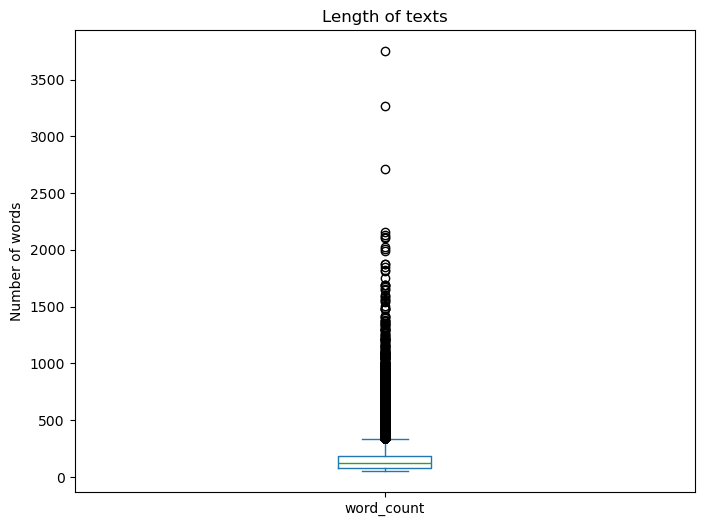

In [15]:
average_length = complete_data['word_count'].mean()
print(f"Average number of words: {average_length}")

# Create a boxplot of the word counts
plt.figure(figsize=(8, 6))
submissions_filtered3["word_count"].plot(kind='box')
plt.title('Length of texts')
plt.ylabel('Number of words')
plt.show()

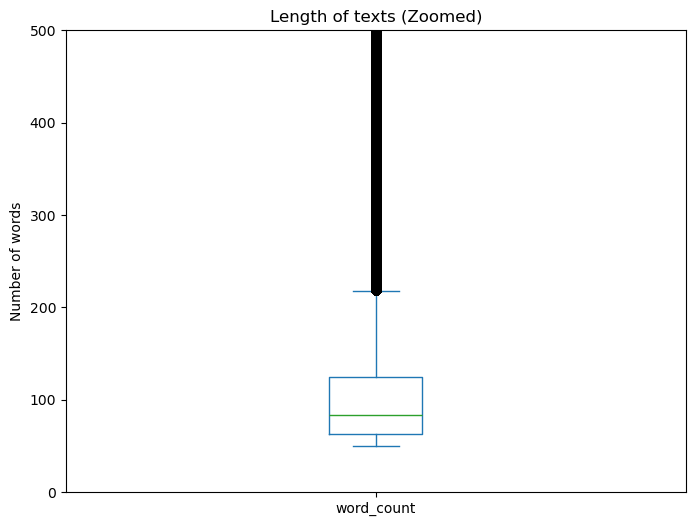

In [16]:
# Take a closer look
plt.figure(figsize=(8, 6))
complete_data["word_count"].plot(kind='box')
plt.title('Length of texts (Zoomed)')
plt.ylabel('Number of words')
plt.ylim(0, 500)  
plt.show()

### Year of publication distribution

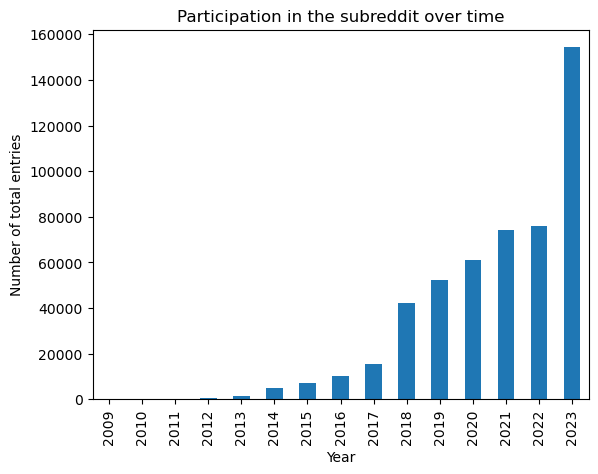

In [17]:
year_counts = complete_data['year'].value_counts().sort_index()

year_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of total entries')
plt.title('Participation in the subreddit over time')
plt.show()

### Observe number of participants in the forum

In [18]:
authors = complete_data["author"]
print("{} unique authors".format(len(set(authors))))


97862 unique authors


## Export final df

In [19]:
#Exclude title and body columns from final data as they create some issues with the parsing of
#the CSV. Also delete in_english column since it won't be useful anymore
final_data = complete_data.drop(["body", "in_english"], axis=1, inplace=False)

In [20]:
final_data.to_csv('cleaned/homeowners_cleaned.csv')

Ensure correct parsing

In [21]:
saved_csv = pd.read_csv("cleaned/homeowners_cleaned.csv")

In [22]:
print(final_data.shape)
print(saved_csv.shape)

(498733, 12)
(498733, 13)
